In [1]:
#!pip install catboost
#!pip install xgboost
#!pip install lightgbm
#!pip install mlxtend

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn

import catboost as cat
import xgboost as xgb
#import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_absolute_error

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from itertools import cycle
#import cPickle

from os import listdir

from datetime import datetime
import time
pd.set_option("display.max_rows", None)

In [3]:
# First we define the error rate for predictions
def error_rate(model,y_test,X_test):
    """Calculates the error rate for a machine learning classification model given a model, a dataset with all the instances and the predicted value"""
    y_pred = model.predict(X_test)
    #error rate
    error = 1.0 - metrics.accuracy_score(y_test, y_pred)
    return error

#function - training / test for a given m - bagging approach
def train_test_bagging(m, X_app, y_app, X_test, y_test, rdm):
    """Calculates the error rate for a given set of data used in a bagging classifier and a given value of m number of estimators"""
    bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=m, random_state=rdm)
    bag.fit(X_app,y_app)
    return error_rate(bag, y_test, X_test)
#end train-test

#function - training / test for a given m - bagging approach
def train_test_baggingK(m, X_app, y_app, X_test, y_test, rdm):
    """Calculates the error rate for a given set of data used in a bagging classifier and a given value of m number of estimators"""
    bag = BaggingClassifier(KNeighborsClassifier(), n_estimators=m, random_state=rdm)
    bag.fit(X_app,y_app)
    return error_rate(bag, y_test, X_test)
#end train-test

In [4]:
file_suffix = "_fromresults_Dataset3_"

#df_training_videos = pd.read_csv("./model/training_videos_attributes2022-01-16_09_59_01.csv")
#df_training_videos = pd.read_csv("./model/training_videos_attributes2022-01-11_06_52_14.csv")
df_training_videos = pd.read_csv("./model/unique_videos_attributes_and_model_inputs2022-01-15_16_09_11.csv")


In [5]:
print("Number of records with known bias (original set):", len(df_training_videos))

Number of records with known bias (original set): 56424


In [6]:
len(df_training_videos[df_training_videos["length"] > 0])

43681

In [7]:
df_training_videos = df_training_videos[df_training_videos["bias_num"]>0]
print("Number of records (original set):", len(df_training_videos))
df_training_videos.head()

Number of records (original set): 12179


,video,duration,view_count,width,height,channel_id,channel_title,published_time,status,length,...,nrc_el_anger_pct,nrc_el_anticipation_pct,nrc_el_disgust_pct,nrc_el_fear_pct,nrc_el_joy_pct,nrc_el_negative_pct,nrc_el_positive_pct,nrc_el_sadness_pct,nrc_el_surprise_pct,nrc_el_trust_pct
0,kisC2LWRnAE,4:37,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,2 weeks ago,Success,660.0,...,0.099291,0.078014,0.056738,0.120567,0.056738,0.212766,0.163121,0.070922,0.028369,0.113475
1,7T9D4Eqs2Jk,2:48,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,412.0,...,0.083333,0.068182,0.030303,0.113636,0.075758,0.136364,0.204545,0.098485,0.060606,0.128788
2,Sl_bKxcJOSk,9:07,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,1568.0,...,0.090909,0.055718,0.026393,0.061584,0.052786,0.117302,0.199413,0.073314,0.149560,0.173021
3,9LoKfCbxVDE,10:16,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,1815.0,...,0.117978,0.075843,0.030899,0.089888,0.053371,0.154494,0.205056,0.058989,0.070225,0.143258
4,0W9OYSuyB3k,5:44,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,971.0,...,0.078341,0.119816,0.018433,0.064516,0.064516,0.147465,0.216590,0.041475,0.115207,0.133641


In [8]:
df_training_videos = df_training_videos[pd.notnull(df_training_videos["bias"])]
df_training_videos = df_training_videos[df_training_videos["length"] > 0]
df_training_videos.dropna(subset=["Flesch"], inplace=True)
print("Number of records with known bias (original set):", len(df_training_videos))

Number of records with known bias (original set): 9768


In [9]:
df_training_videos.bias.value_counts()

LC    4501
C     2661
RC    1015
L      934
R      657
Name: bias, dtype: int64

In [10]:
# Creation of modelling datasets

df_training_videos_l = df_training_videos[df_training_videos["bias"] == "L"]
df_training_videos_cl = df_training_videos[df_training_videos["bias"] == "LC"]
df_training_videos_c = df_training_videos[df_training_videos["bias"] == "C"]
df_training_videos_cr = df_training_videos[df_training_videos["bias"] == "RC"]
df_training_videos_r = df_training_videos[df_training_videos["bias"] == "R"]

# Creation of a dataset based on the class with the least instances

l_videos = 2500
cl_videos = 2500
c_videos = 2500
cr_videos = 2500
r_videos = 2500

df_training_videos_0 = df_training_videos_l.sample(n = min(l_videos, len(df_training_videos_l))) # The df on the left is numbered "1" (one) while the one on the right is "l" (the letter l, for left)
df_training_videos_0 = df_training_videos_0.append(df_training_videos_cl.sample(n = min(cl_videos, len(df_training_videos_cl))))
df_training_videos_0 = df_training_videos_0.append(df_training_videos_c.sample(n = min(c_videos, len(df_training_videos_c))))
df_training_videos_0 = df_training_videos_0.append(df_training_videos_cr.sample(n = min(cr_videos, len(df_training_videos_cr))))
df_training_videos_0 = df_training_videos_0.append(df_training_videos_r.sample(n = min(r_videos, len(df_training_videos_r))))

In [12]:
df_training_videos_0.bias.value_counts()

LC    2500
C     2500
RC    1015
L      934
R      657
Name: bias, dtype: int64

In [13]:
date = time.strftime("%Y-%m-%d_%H_%M_%S")
file_name = "model/training_videos_0" + file_suffix+ date + ".csv"
df_training_videos_0.to_csv(file_name, index=False)

In [14]:
df_training_videos_0 = df_training_videos_0[df_training_videos_0.columns[62:]].drop("bias", axis = 1)

In [15]:
df_training_videos_0.columns

Index(['Flesch.Kincaid', 'bias_num', 'lsd_count', 'lsd_pct', 'afinn_count',
       'afinn_pct', 'geninqposneg_count', 'geninqposneg_pct', 'huliu_count',
       'huliu_pct', 'lm_count', 'lm_pct', 'lm_negative_pct', 'lm_positive_pct',
       'lm_uncertainty_pct', 'lm_litigious_pct', 'lm_constraining_pct',
       'lm_superfluous_pct', 'lm_interesting_pct', 'lm_modal_words_strong_pct',
       'lgpp_count', 'lgpp_pct', 'lgpp_culture_pct', 'lgpp_economy_pct',
       'lgpp_environment_pct', 'lgpp_groups_pct', 'lgpp_institutions_pct',
       'lgpp_law_and_order_pct', 'lgpp_rural_pct', 'lgpp_urban_pct',
       'lgpp_values_pct', 'nrc_el_count', 'nrc_el_pct', 'nrc_el_anger_pct',
       'nrc_el_anticipation_pct', 'nrc_el_disgust_pct', 'nrc_el_fear_pct',
       'nrc_el_joy_pct', 'nrc_el_negative_pct', 'nrc_el_positive_pct',
       'nrc_el_sadness_pct', 'nrc_el_surprise_pct', 'nrc_el_trust_pct'],
      dtype='object')

In [16]:
bias_col = df_training_videos_0.pop("bias_num")
df_training_videos_0.insert(0, "bias_num", bias_col)

In [17]:
seed = 47

In [18]:
df_training_videos_num_i = df_training_videos_0

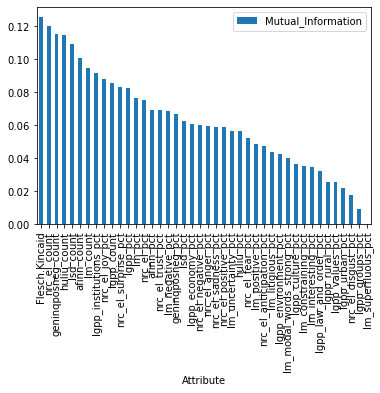

,Attribute,Mutual_Information
0,Flesch.Kincaid,0.125448
30,nrc_el_count,0.120057
5,geninqposneg_count,0.115295
7,huliu_count,0.114820
1,lsd_count,0.109336
3,afinn_count,0.100420
9,lm_count,0.094394
25,lgpp_institutions_pct,0.091683
36,nrc_el_joy_pct,0.088092
19,lgpp_count,0.085438


In [19]:
X = df_training_videos_num_i.to_numpy()[:,1:]
y = df_training_videos_num_i.to_numpy()[:,0].astype('int')
mic = mutual_info_classif(X, y, random_state=seed)
columns = df_training_videos_num_i.columns[1:]
mic_df = pd.DataFrame({'Attribute':df_training_videos_num_i.columns[1:], 'Mutual_Information':mic}).sort_values(by="Mutual_Information", ascending=False)
mic_df.plot('Attribute', 'Mutual_Information', kind='bar')
plt.show()
mic_df

,Flesch.Kincaid,lsd_count,lsd_pct,afinn_count,afinn_pct,geninqposneg_count,geninqposneg_pct,huliu_count,huliu_pct,lm_count,...,nrc_el_anger_pct,nrc_el_anticipation_pct,nrc_el_disgust_pct,nrc_el_fear_pct,nrc_el_joy_pct,nrc_el_negative_pct,nrc_el_positive_pct,nrc_el_sadness_pct,nrc_el_surprise_pct,nrc_el_trust_pct
Flesch.Kincaid,1.000000,0.249124,0.029177,0.259034,0.024055,0.260153,0.109998,0.245202,0.051456,0.181080,...,0.079608,0.021855,0.026120,0.085830,-0.012019,0.068642,0.074176,0.065284,-0.063652,0.088336
lsd_count,0.249124,1.000000,0.067736,0.988350,0.044722,0.984524,0.099646,0.993035,0.078447,0.941404,...,0.039404,0.045746,0.010049,0.031651,-0.014084,0.027177,0.107545,-0.011379,-0.014802,0.141351
lsd_pct,0.029177,0.067736,1.000000,0.059790,0.786161,0.010973,0.685492,0.047848,0.846979,0.024886,...,0.335385,0.084410,0.254105,0.316026,0.233938,0.326736,0.115615,0.228866,0.234245,0.124611
afinn_count,0.259034,0.988350,0.059790,1.000000,0.076911,0.982648,0.119782,0.988399,0.086098,0.913727,...,0.032560,0.060153,0.006984,0.019960,0.012434,0.016326,0.105314,-0.008544,0.000434,0.134495
afinn_pct,0.024055,0.044722,0.786161,0.076911,1.000000,0.015574,0.685806,0.040237,0.739540,-0.000580,...,0.226077,0.129525,0.172522,0.183005,0.349585,0.159220,0.088497,0.186055,0.281791,0.080113
geninqposneg_count,0.260153,0.984524,0.010973,0.982648,0.015574,1.000000,0.109567,0.986372,0.041344,0.928011,...,0.014381,0.075788,-0.011201,0.005554,-0.001028,0.007320,0.123817,-0.024145,-0.007218,0.150181
geninqposneg_pct,0.109998,0.099646,0.685492,0.119782,0.685806,0.109567,1.000000,0.100656,0.708601,0.048552,...,0.194704,0.290710,0.142167,0.141043,0.404729,0.178596,0.254162,0.151068,0.370932,0.217541
huliu_count,0.245202,0.993035,0.047848,0.988399,0.040237,0.986372,0.100656,1.000000,0.091269,0.935527,...,0.031897,0.055139,0.011235,0.020851,-0.010751,0.027492,0.106519,-0.010907,-0.007528,0.138248
huliu_pct,0.051456,0.078447,0.846979,0.086098,0.739540,0.041344,0.708601,0.091269,1.000000,0.037770,...,0.304495,0.143324,0.273934,0.253742,0.243783,0.350689,0.117423,0.226415,0.268779,0.129217
lm_count,0.181080,0.941404,0.024886,0.913727,-0.000580,0.928011,0.048552,0.935527,0.037770,1.000000,...,0.066307,0.018677,0.003423,0.055759,-0.086767,0.041197,0.085251,-0.014533,-0.051225,0.159654


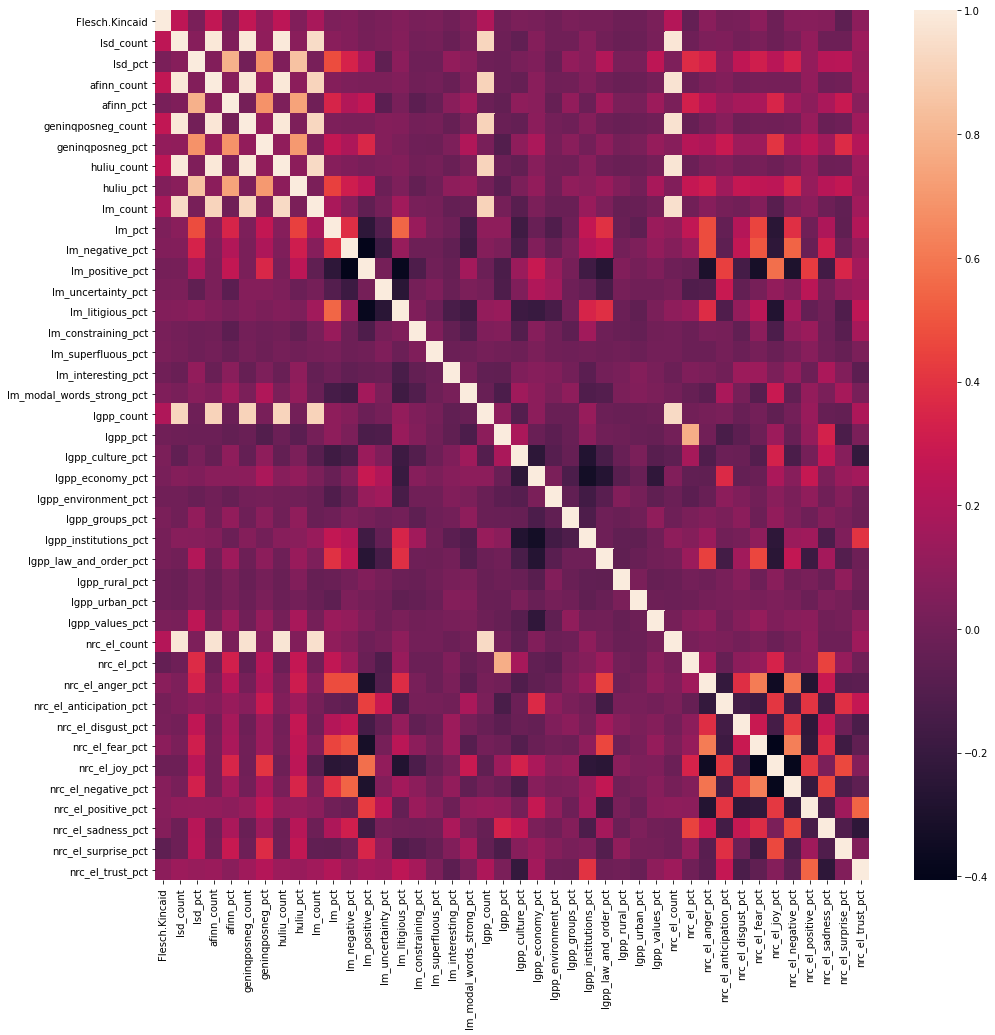

In [20]:
plt.figure(figsize=(16, 16))
sn.heatmap(df_training_videos_num_i.iloc[:,1:].corr())
df_training_videos_num_i.iloc[:,1:].corr()

,Flesch.Kincaid,lsd_count,lsd_pct,lm_pct,lm_negative_pct,lm_positive_pct,lm_uncertainty_pct,lm_litigious_pct,lm_constraining_pct,lm_superfluous_pct,...,nrc_el_anger_pct,nrc_el_anticipation_pct,nrc_el_disgust_pct,nrc_el_fear_pct,nrc_el_joy_pct,nrc_el_negative_pct,nrc_el_positive_pct,nrc_el_sadness_pct,nrc_el_surprise_pct,nrc_el_trust_pct
Flesch.Kincaid,1.000000,0.249124,0.029177,0.038852,0.055297,0.015363,0.028419,0.059679,0.026541,0.029011,...,0.079608,0.021855,0.026120,0.085830,-0.012019,0.068642,0.074176,0.065284,-0.063652,0.088336
lsd_count,0.249124,1.000000,0.067736,0.081125,0.055771,0.016926,0.035720,0.065846,0.007948,0.012012,...,0.039404,0.045746,0.010049,0.031651,-0.014084,0.027177,0.107545,-0.011379,-0.014802,0.141351
lsd_pct,0.029177,0.067736,1.000000,0.474147,0.340275,0.183792,-0.058855,0.082897,-0.005794,-0.008348,...,0.335385,0.084410,0.254105,0.316026,0.233938,0.326736,0.115615,0.228866,0.234245,0.124611
lm_pct,0.038852,0.081125,0.474147,1.000000,0.381475,-0.231023,-0.096634,0.549147,0.131074,0.023353,...,0.475520,-0.040706,0.218337,0.451793,-0.247090,0.388228,-0.004921,0.193270,-0.054682,0.213932
lm_negative_pct,0.055297,0.055771,0.340275,0.381475,1.000000,-0.398716,-0.184606,0.125020,-0.014324,-0.014709,...,0.476539,-0.061717,0.259840,0.501357,-0.230579,0.542506,-0.031489,0.313590,-0.010122,0.118340
lm_positive_pct,0.015363,0.016926,0.183792,-0.231023,-0.398716,1.000000,0.015564,-0.373622,-0.116354,-0.001050,...,-0.297353,0.434644,-0.150444,-0.318821,0.573949,-0.293927,0.424709,-0.159853,0.347406,0.166232
lm_uncertainty_pct,0.028419,0.035720,-0.058855,-0.096634,-0.184606,0.015564,1.000000,-0.249614,0.014493,0.047204,...,-0.101570,0.283992,-0.043914,0.021885,0.105385,0.056845,0.238323,0.019247,0.113622,0.143487
lm_litigious_pct,0.059679,0.065846,0.082897,0.549147,0.125020,-0.373622,-0.249614,1.000000,0.044768,-0.019384,...,0.378776,-0.112616,0.115062,0.239376,-0.275755,0.163961,-0.039564,0.005195,-0.110286,0.251301
lm_constraining_pct,0.026541,0.007948,-0.005794,0.131074,-0.014324,-0.116354,0.014493,0.044768,1.000000,0.047386,...,0.023697,0.019570,-0.049485,0.090874,-0.120923,0.091787,0.133454,-0.008445,-0.080004,0.175203
lm_superfluous_pct,0.029011,0.012012,-0.008348,0.023353,-0.014709,-0.001050,0.047204,-0.019384,0.047386,1.000000,...,-0.017472,0.011877,-0.021174,0.016905,-0.025662,0.013852,0.071967,-0.004510,-0.036770,0.033556


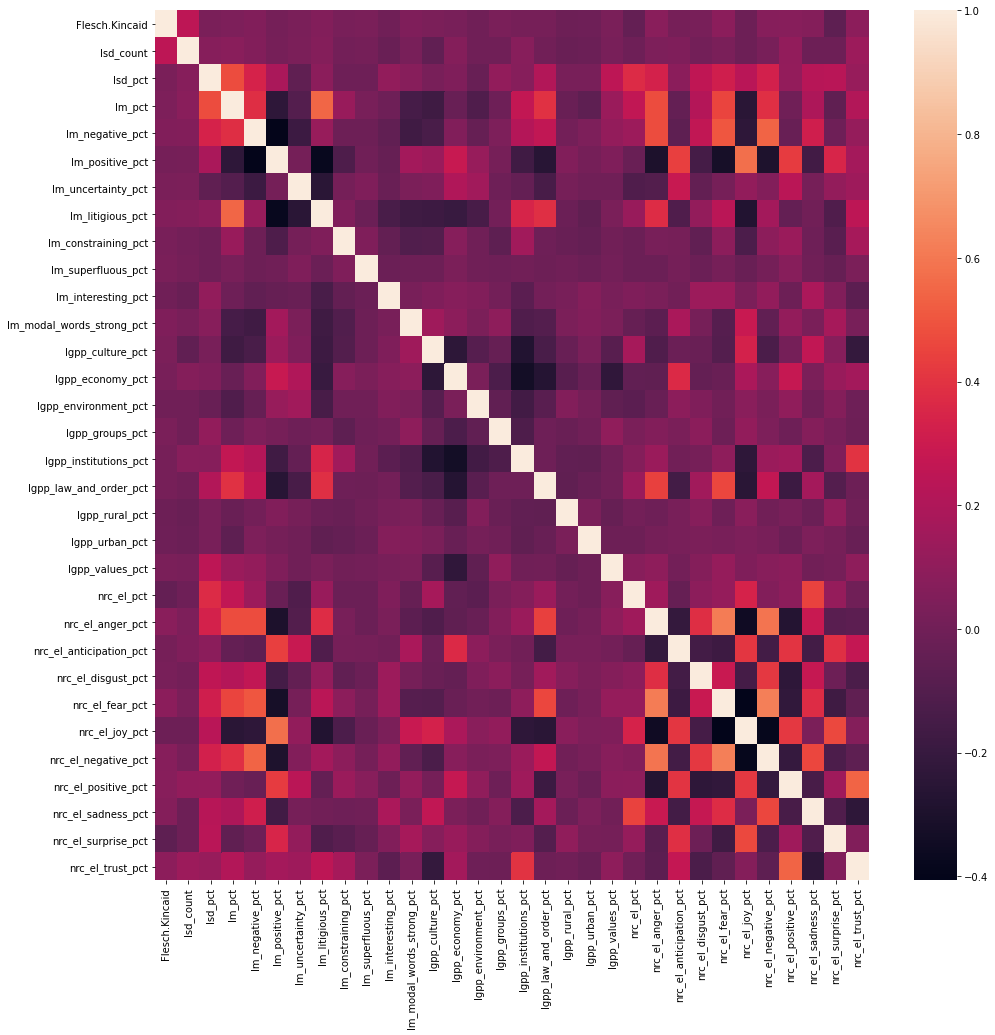

In [21]:
feature_drop = ["afinn_count", "geninqposneg_count", "huliu_count", "lm_count", "lgpp_count", "nrc_el_count", "lgpp_pct", "afinn_pct", "geninqposneg_pct", "huliu_pct"]
df_training_videos_num_i = df_training_videos_num_i.drop(feature_drop, axis = 1)
plt.figure(figsize=(16, 16))
sn.heatmap(df_training_videos_num_i.iloc[:,1:].corr())
df_training_videos_num_i.iloc[:,1:].corr()

In [22]:
X = df_training_videos_num_i.to_numpy()[:, 1:]
y = df_training_videos_num_i.to_numpy()[:, 0].astype('int')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## KNN

In [24]:
knn_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [25]:
parametres = [{"n_neighbors":[10, 20, 30, 40, 50, 60]}]
grid_knn = GridSearchCV(cv = 10, estimator=KNeighborsClassifier(), param_grid=parametres, scoring="accuracy", verbose = True)
grille_knn = grid_knn.fit(X_train, y_train)

best_estimators_knn = grille_knn.best_params_["n_neighbors"]
print("Best neighbors: ", best_estimators_knn)

best_score_knn = grille_knn.best_score_
print("Best score: ", best_score_knn)

knn = KNeighborsClassifier(n_neighbors=best_estimators_knn)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

knn_accuracy = metrics.accuracy_score(y_test, y_pred_knn)

print("Random Forest Accuracy: ", knn_accuracy)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   23.0s finished


Best neighbors:  30
Best score:  0.5243272513179501
Random Forest Accuracy:  0.5348226018396847


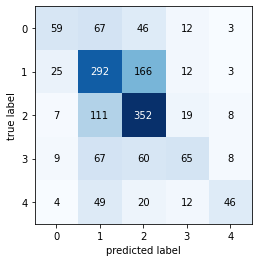

In [26]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_knn))
plt.show()

In [27]:
y_test_b = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_b = label_binarize(y_pred_knn, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

knn_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)

print("Accuracy: ", knn_accuracy)

Accuracy:  0.5348226018396847


In [28]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

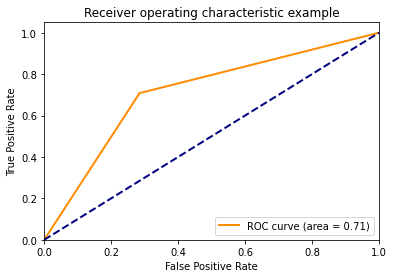

In [29]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

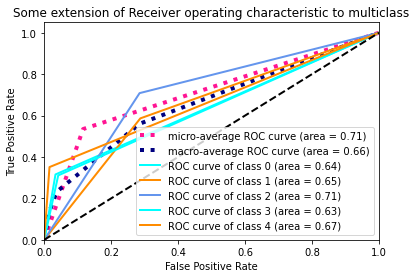

In [30]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [31]:
knn_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Gaussian Naive Bayes

In [32]:
gnb_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [33]:
#parametres = [{"n_neighbors":[10, 20, 30, 40, 50, 60]}]
#grid_gnb = GridSearchCV(cv = 10, estimator=KNeighborsClassifier(), param_grid=parametres, scoring="accuracy", verbose = True)

#grille_gnb = grid_gnb.fit(X_train, y_train)

#best_estimators_gnb = grille_gnb.best_params_["n_neighbors"]
#print("Best neighbors: ", best_estimators_gnb)

#best_score_gnb = grille_gnb.best_score_
#print("Best score: ", best_score_gnb)

gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred_gnb = gnb.predict(X_test)

gnb_accuracy = metrics.accuracy_score(y_test, y_pred_gnb)

print("Random Forest Accuracy: ", gnb_accuracy)

Random Forest Accuracy:  0.4454664914586071


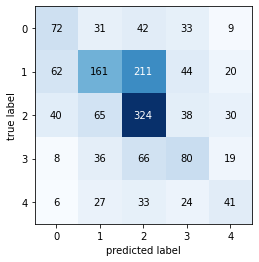

In [34]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_gnb))
plt.show()

In [35]:
y_test_b = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_b = label_binarize(y_pred_gnb, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

gnb_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)

print("Accuracy: ", gnb_accuracy)

Accuracy:  0.4454664914586071


In [36]:
gnb_end = time.strftime("%Y-%m-%d_%H_%M_%S")

##  Random Forest

In [37]:
rf_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [38]:
parametres = [{"n_estimators":[100, 150, 200, 250, 300, 350]}]
grid_rf = GridSearchCV(cv = 10, estimator=RandomForestClassifier(), param_grid=parametres, scoring="accuracy", verbose = True)
grille_rf = grid_rf.fit(X_train, y_train)

best_estimators_rf = grille_rf.best_params_["n_estimators"]
print("Best estimators: ", best_estimators_rf)

best_score_rf = grille_rf.best_score_
print("Best score: ", best_score_rf)

rf = RandomForestClassifier(n_estimators=best_estimators_rf, random_state=seed)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)

print("Random Forest Accuracy: ", rf_accuracy)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  5.3min finished


Best estimators:  250
Best score:  0.5714947390026791
Random Forest Accuracy:  0.5637319316688568


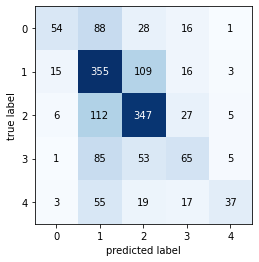

In [39]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_rf))
plt.show()

In [40]:
y_test_b = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_b = label_binarize(y_pred_rf, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

rf_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)

print("Accuracy: ", rf_accuracy)

Accuracy:  0.5637319316688568


In [41]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

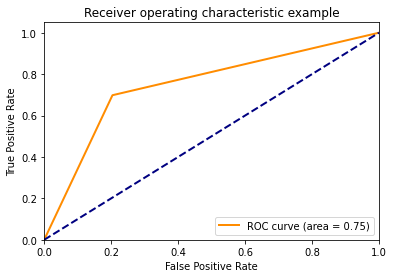

In [42]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

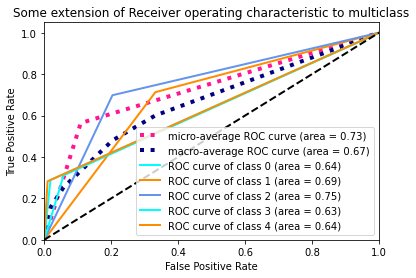

In [43]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [44]:
rf_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Bagging (Decision Tree Classifier)

In [45]:
bag_dtc_start = time.strftime("%Y-%m-%d_%H_%M_%S")

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 26.4min finished


Best estimators:  200
Best score:  0.5698491919453808
Bagging (Decision Tree Classifier) Accuracy:  0.5519053876478318


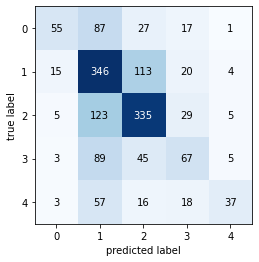

Accuracy:  0.5519053876478318


In [46]:
parametres = [{"n_estimators":[100, 150, 200, 250, 300, 350]}]
bag_dtc = BaggingClassifier(DecisionTreeClassifier(), random_state=seed)
grid_bag_dtc = GridSearchCV(cv = 10, estimator=bag_dtc, param_grid=parametres, scoring="accuracy", verbose=1)
grille_bag_dtc = grid_bag_dtc.fit(X_train, y_train)

best_estimators_bag_dtc = grille_bag_dtc.best_params_["n_estimators"]
print("Best estimators: ", best_estimators_bag_dtc)

best_score_bag_dtc = grille_bag_dtc.best_score_
print("Best score: ", best_score_bag_dtc)

bag_dtc = BaggingClassifier(DecisionTreeClassifier(), n_estimators=best_estimators_bag_dtc, random_state=seed)
bag_dtc.fit(X_train,y_train)
y_pred_bag_dtc = bag_dtc.predict(X_test)

bag_dtc_accuracy = metrics.accuracy_score(y_test, y_pred_bag_dtc)

print("Bagging (Decision Tree Classifier) Accuracy: ", bag_dtc_accuracy)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_bag_dtc))
plt.show()

y_pred_b = label_binarize(y_pred_bag_dtc, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

bag_dtc_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)
print("Accuracy: ", bag_dtc_accuracy)

In [47]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

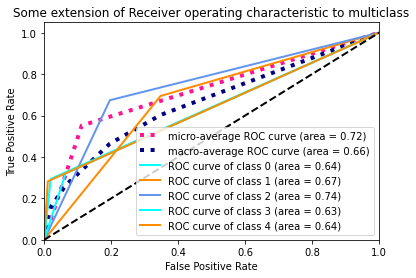

In [48]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [49]:
bag_dtc_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Bagging (K-Nearest Neighbour)

In [50]:
bag_knn_start = time.strftime("%Y-%m-%d_%H_%M_%S")

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 58.2min finished


Best estimators:  200
Best score:  0.5085442593552847
Bagging (Decision Tree Classifier) Accuracy:  0.5519053876478318


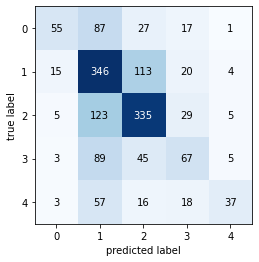

Accuracy:  0.5519053876478318


In [51]:
parametres = [{"n_estimators":[100, 150, 200, 250, 300, 350]}]
bag_knn = BaggingClassifier(KNeighborsClassifier(), random_state=seed)
grid_bag_knn = GridSearchCV(cv = 10, estimator=bag_knn, param_grid=parametres, scoring="accuracy", verbose=1)
grille_bag_knn = grid_bag_knn.fit(X_train, y_train)

best_estimators_bag_knn = grille_bag_knn.best_params_["n_estimators"]
print("Best estimators: ", best_estimators_bag_knn)

best_score_bag_knn = grille_bag_knn.best_score_
print("Best score: ", best_score_bag_knn)

bag_knn = BaggingClassifier(DecisionTreeClassifier(), n_estimators=best_estimators_bag_knn, random_state=seed)
bag_knn.fit(X_train, y_train)
y_pred_bag_knn = bag_knn.predict(X_test)

bag_knn_accuracy = metrics.accuracy_score(y_test, y_pred_bag_knn)

print("Bagging (Decision Tree Classifier) Accuracy: ", bag_knn_accuracy)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_bag_knn))
plt.show()

y_pred_b = label_binarize(y_pred_bag_knn, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

bag_knn_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)
print("Accuracy: ", bag_knn_accuracy)

In [52]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

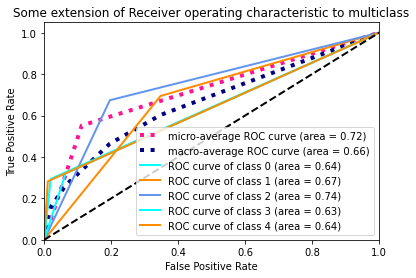

In [53]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [54]:
bag_knn_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Gradient Boosted Trees

In [55]:
cat_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [56]:
X_display = df_training_videos_num_i.drop('bias_num', axis = 1)
y_display = df_training_videos_num_i['bias_num'].to_numpy()

In [57]:
# create a train/test split with catboost
d_test_cat = cat.Pool(X_test, y_test)

In [58]:
model_cat = cat.CatBoostClassifier(iterations = 5000
                                   , learning_rate = 0.01
                                   , loss_function = "MultiClass"
                                   , random_seed = seed
#                                   , depth = 8)
                                   , depth = 4)

model_cat.fit(X_train
                , y_train
                , eval_set = d_test_cat
                , verbose_eval=500
                , early_stopping_rounds=400
                , plot = True)

y_pred_cat_array = model_cat.predict(X_test)

print("\nTest  Accuracy : %.2f"%model_cat.score(X_test, y_test))
print("Train Accuracy : %.2f"%model_cat.score(X_train, y_train))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6037564	test: 1.6039377	best: 1.6039377 (0)	total: 87.8ms	remaining: 7m 19s
500:	learn: 1.1395086	test: 1.1943208	best: 1.1943208 (500)	total: 8.47s	remaining: 1m 16s
1000:	learn: 1.0507182	test: 1.1387929	best: 1.1387929 (1000)	total: 15.1s	remaining: 1m
1500:	learn: 0.9875365	test: 1.1068026	best: 1.1068026 (1500)	total: 21.7s	remaining: 50.5s
2000:	learn: 0.9417276	test: 1.0898527	best: 1.0898527 (2000)	total: 28s	remaining: 41.9s
2500:	learn: 0.9029460	test: 1.0786411	best: 1.0786411 (2500)	total: 34.4s	remaining: 34.4s
3000:	learn: 0.8696138	test: 1.0709545	best: 1.0709502 (2999)	total: 41.5s	remaining: 27.7s
3500:	learn: 0.8389789	test: 1.0652654	best: 1.0652654 (3500)	total: 49.1s	remaining: 21s
4000:	learn: 0.8117845	test: 1.0607069	best: 1.0607069 (4000)	total: 56s	remaining: 14s
4500:	learn: 0.7867371	test: 1.0573686	best: 1.0573686 (4500)	total: 1m 3s	remaining: 7.04s
4999:	learn: 0.7624956	test: 1.0547418	best: 1.0547418 (4999)	total: 1m 11s	remaining: 0us

best

In [59]:
y_pred_cat = []
for i in range(len(y_pred_cat_array)):
    y_pred_cat.append(y_pred_cat_array[i][0])
y_pred_cat = np.asarray(y_pred_cat)

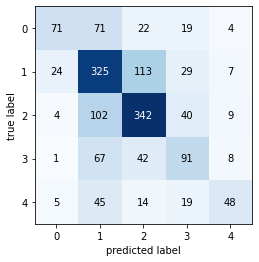

In [60]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_cat))
plt.show()

In [61]:
y_pred_b = label_binarize(y_pred_cat, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

cat_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)

print("Accuracy: ", cat_accuracy)

Accuracy:  0.576215505913272


In [62]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

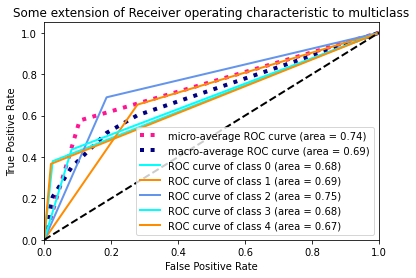

In [63]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [64]:
#file_name = "model/catboost_0" + date + ".cat"
#with open(file_name, 'wb') as fid:
    #cPickle.dump(bag, fid)

In [65]:
cat_end = time.strftime("%Y-%m-%d_%H_%M_%S")

El método **CatBoost** se detiene luego de 500 iteraciones al detectar posible overfitting, reprotando un error observado de 55% correspondiente a la iteración 390.

Además se probó una profundidad máxima de 4, arrojando el mismo error, llegando al resultado en 1247 iteraciones. También se probaron varios learning rate (0.02, 0.05, 0.001) con 4 de profundidad, obteninedo prácticamente el mismo error, con la notable diferencia de learning_rate de 0.001 que subía casi dos puntos.

Se conserva el modelo con depth=8 y learning_rate=0.01 como final.

## XGBoost

In [66]:
xgb_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [67]:
# create a train/test split with xgboost
d_train_xgb = xgb.DMatrix(X_train, label=y_train)
d_test_xgb = xgb.DMatrix(X_test, label=y_test)

In [68]:
params = {
    "learning_rate": 0.01,
    "objective": "multi:softmax",
    "num_class": 6,
    "eval_metric": "mlogloss",
    "max_depth": 4,
    "max_leaves": 4
}

model_xgb = xgb.train(params
                        , d_train_xgb
                        , 40000
                        , evals = [(d_test_xgb, "Test")]
                        , verbose_eval=1000
                        , early_stopping_rounds=1000)

y_pred_xgb_array = model_xgb.predict(d_test_xgb)
y_train_xgb_array = model_xgb.predict(d_train_xgb)

[0]	Test-mlogloss:1.78469
[1000]	Test-mlogloss:1.09821
[2000]	Test-mlogloss:1.08632
[2804]	Test-mlogloss:1.08949


In [69]:
y_train_xgb_array = model_xgb.predict(d_train_xgb)

In [70]:
print("\nTest  Accuracy : %.2f"%accuracy_score(y_test, y_pred_xgb_array))
print("Train Accuracy : %.2f"%accuracy_score(y_train, y_train_xgb_array))

print("\nClassification Report : ")
print(classification_report(y_test, y_pred_xgb_array))


Test  Accuracy : 0.57
Train Accuracy : 0.90

Classification Report : 
              precision    recall  f1-score   support

           1       0.62      0.32      0.42       187
           2       0.53      0.65      0.58       498
           3       0.63      0.69      0.66       497
           4       0.45      0.40      0.43       209
           5       0.61      0.36      0.45       131

    accuracy                           0.57      1522
   macro avg       0.57      0.49      0.51      1522
weighted avg       0.57      0.57      0.56      1522



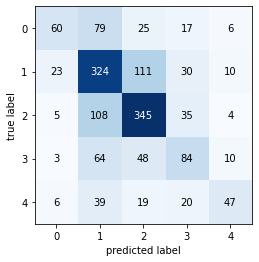

In [71]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_xgb_array))
plt.show()

In [72]:
y_pred_xgb_array_b = label_binarize(y_pred_xgb_array, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

xgb_accuracy = metrics.accuracy_score(y_test_b, y_pred_xgb_array_b)

print("Accuracy: ", xgb_accuracy)

Accuracy:  0.5650459921156373


In [73]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_xgb_array_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_xgb_array_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

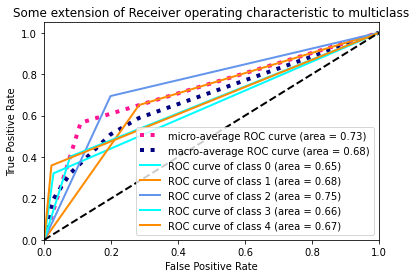

In [74]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

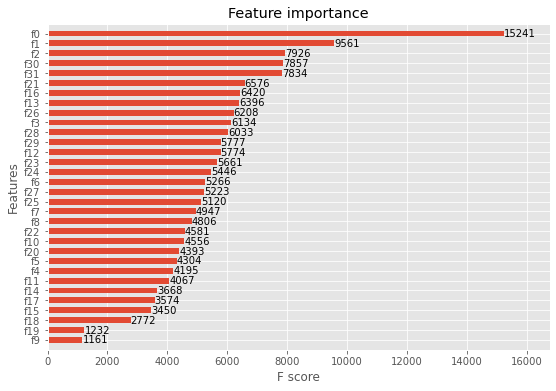

In [75]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111)
    xgb.plotting.plot_importance(model_xgb, ax=ax, height=0.6, importance_type="weight")

In [76]:
xgb_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Metrics Summary

In [77]:
print("Start time: ", gnb_start)

print("**** Gaussian Naive Bayes ****")
print("")
print("Accuracy: %.2f" % gnb_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_gnb, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_gnb, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_gnb, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_gnb)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_gnb))
print("Elapsed: %.2f" % (abs(datetime.strptime(gnb_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(gnb_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))


print("")
print("")
print("**** KNN ****")
print("")
print("Best Estimators: ", best_estimators_knn)
print("Accuracy: %.2f" % knn_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_knn, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_knn, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_knn, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_knn)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_knn))
print("Elapsed: %.2f" % (abs(datetime.strptime(knn_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(knn_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("**** Random Forest ****")
print("")
print("Best Estimators: ", best_estimators_rf)
print("Accuracy: %.2f" % rf_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_rf, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_rf, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_rf, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_rf)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_rf))
print("Elapsed: %.2f" % (abs(datetime.strptime(rf_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(rf_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("")
print("")
print("**** Bagging (Decision Tree Classifier) ****")
print("")
print("Best Estimators: ", best_estimators_bag_dtc)
print("Accuracy: %.2f" % bag_dtc_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_bag_dtc, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_bag_dtc, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_bag_dtc, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_bag_dtc)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_bag_dtc))
print("Elapsed: %.2f" % (abs(datetime.strptime(bag_dtc_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(bag_dtc_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("")
print("")
print("**** Bagging (K-Nearest Neighbours) ****")
print("")
print("Best Estimators: ", best_estimators_bag_knn)
print("Accuracy: %.2f" % bag_knn_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_bag_knn, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_bag_knn, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_bag_knn, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_bag_knn)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_bag_knn))
print("Elapsed: %.2f" % (abs(datetime.strptime(bag_knn_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(bag_knn_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("")
print("")
print("**** Catboost ****")
print("")
print("Accuracy: %.2f" % cat_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_cat, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_cat, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_cat, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_cat)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_cat))
print("Elapsed: %.2f" % (abs(datetime.strptime(cat_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(cat_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("")
print("")
print("**** XGBoost ****")
print("")
print("Accuracy: %.2f" % xgb_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_xgb_array, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_xgb_array, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_xgb_array, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_xgb_array)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_xgb_array))
print("Elapsed: %.2f" % (abs(datetime.strptime(xgb_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(xgb_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("End time: ", xgb_end)

Start time:  2022-01-25_12_55_46
**** Gaussian Naive Bayes ****

Accuracy: 0.45
F1 Scode micro: 0.45
F1 Scode macro: 0.41
F1 Scode weighted: 0.44
precision: [0.38297872 0.503125   0.47928994 0.3652968  0.34453782]
recall: [0.38502674 0.32329317 0.65191147 0.38277512 0.3129771 ]
fscore: [0.384      0.39364303 0.55242967 0.37383178 0.328     ]
support: [187 498 497 209 131]
MEA: 0.85
Elapsed: 0.00


**** KNN ****

Best Estimators:  30
Accuracy: 0.53
F1 Scode micro: 0.53
F1 Scode macro: 0.48
F1 Scode weighted: 0.52
precision: [0.56730769 0.49829352 0.54658385 0.54166667 0.67647059]
recall: [0.31550802 0.58634538 0.7082495  0.31100478 0.35114504]
fscore: [0.40549828 0.53874539 0.61700263 0.39513678 0.46231156]
support: [187 498 497 209 131]
MEA: 0.68
Elapsed: 0.42
**** Random Forest ****

Best Estimators:  250
Accuracy: 0.56
F1 Scode micro: 0.56
F1 Scode macro: 0.49
F1 Scode weighted: 0.55
precision: [0.6835443  0.51079137 0.62410072 0.46099291 0.7254902 ]
recall: [0.28877005 0.71285141 0.

# Classifying Unique Videos Dataset

In [78]:
#df_unique_videos = pd.read_csv("./model/unique_videos_attributes2022-01-16_09_59_01.csv")
df_unique_videos = pd.read_csv("./model/unique_videos_attributes_and_model_inputs2022-01-15_16_09_11.csv")
print("Number of records (unique set):", len(df_unique_videos))
df_unique_videos.head()

Number of records (unique set): 56424


,video,duration,view_count,width,height,channel_id,channel_title,published_time,status,length,...,nrc_el_anger_pct,nrc_el_anticipation_pct,nrc_el_disgust_pct,nrc_el_fear_pct,nrc_el_joy_pct,nrc_el_negative_pct,nrc_el_positive_pct,nrc_el_sadness_pct,nrc_el_surprise_pct,nrc_el_trust_pct
0,kisC2LWRnAE,4:37,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,2 weeks ago,Success,660.0,...,0.099291,0.078014,0.056738,0.120567,0.056738,0.212766,0.163121,0.070922,0.028369,0.113475
1,7T9D4Eqs2Jk,2:48,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,412.0,...,0.083333,0.068182,0.030303,0.113636,0.075758,0.136364,0.204545,0.098485,0.060606,0.128788
2,Sl_bKxcJOSk,9:07,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,1568.0,...,0.090909,0.055718,0.026393,0.061584,0.052786,0.117302,0.199413,0.073314,0.149560,0.173021
3,9LoKfCbxVDE,10:16,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,1815.0,...,0.117978,0.075843,0.030899,0.089888,0.053371,0.154494,0.205056,0.058989,0.070225,0.143258
4,0W9OYSuyB3k,5:44,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,971.0,...,0.078341,0.119816,0.018433,0.064516,0.064516,0.147465,0.216590,0.041475,0.115207,0.133641


In [79]:
df_unique_videos.loc[df_unique_videos["bias"]=="L", "bias_num"] = 1
df_unique_videos.loc[df_unique_videos["bias"]=="LC", "bias_num"] = 2
df_unique_videos.loc[df_unique_videos["bias"]=="C", "bias_num"] = 3
df_unique_videos.loc[df_unique_videos["bias"]=="RC", "bias_num"] = 4
df_unique_videos.loc[df_unique_videos["bias"]=="R", "bias_num"] = 5

In [80]:
df_unique_videos["lsd_count"] = df_unique_videos["lsd_negative"] + df_unique_videos["lsd_positive"]
df_unique_videos["lsd_pct"] = df_unique_videos["lsd_count"] / df_unique_videos["length"]

df_unique_videos["afinn_count"] = df_unique_videos["afinn_negative"] + df_unique_videos["afinn_positive"]
df_unique_videos["afinn_pct"] = df_unique_videos["afinn_count"] / df_unique_videos["length"]

df_unique_videos["geninqposneg_count"] = df_unique_videos["geninqposneg_negative"] + df_unique_videos["geninqposneg_positive"]
df_unique_videos["geninqposneg_pct"] = df_unique_videos["geninqposneg_count"] / df_unique_videos["length"]

df_unique_videos["huliu_count"] = df_unique_videos["huliu_negative"] + df_unique_videos["huliu_positive"]
df_unique_videos["huliu_pct"] = df_unique_videos["huliu_count"] / df_unique_videos["length"]

df_unique_videos["lm_count"] = df_unique_videos["lm_negative"] + df_unique_videos["lm_positive"] + df_unique_videos["lm_uncertainty"] + df_unique_videos["lm_litigious"] + df_unique_videos["lm_constraining"] + df_unique_videos["lm_superfluous"] + df_unique_videos["lm_interesting"] + df_unique_videos["lm_modal_words_strong"]
df_unique_videos["lm_pct"] = df_unique_videos["lm_count"] / df_unique_videos["length"]

df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_negative_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_positive_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_uncertainty_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_litigious_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_constraining_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_superfluous_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_interesting_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_modal_words_strong_pct"] = 0

df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_negative_pct"] = df_unique_videos["lm_negative"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_positive_pct"] = df_unique_videos["lm_positive"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_uncertainty_pct"] = df_unique_videos["lm_uncertainty"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_litigious_pct"] = df_unique_videos["lm_litigious"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_constraining_pct"] = df_unique_videos["lm_constraining"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_superfluous_pct"] = df_unique_videos["lm_superfluous"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_interesting_pct"] = df_unique_videos["lm_interesting"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_modal_words_strong_pct"] = df_unique_videos["lm_modal_words_strong"] / df_unique_videos["lm_count"]

df_unique_videos["lgpp_count"] = df_unique_videos["lgpp_culture"] + df_unique_videos["lgpp_economy"] + df_unique_videos["lgpp_environment"] + df_unique_videos["lgpp_groups"] + df_unique_videos["lgpp_institutions"] + df_unique_videos["lgpp_law_and_order"] + df_unique_videos["lgpp_rural"] + df_unique_videos["lgpp_urban"] + df_unique_videos["lgpp_values"]
df_unique_videos["lgpp_pct"] = df_unique_videos["lgpp_count"] / df_unique_videos["length"]

df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_culture_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_economy_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_environment_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_groups_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_institutions_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_law_and_order_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_rural_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_urban_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_values_pct"] = 0

df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_culture_pct"] = df_unique_videos["lgpp_culture"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_economy_pct"] = df_unique_videos["lgpp_economy"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_environment_pct"] = df_unique_videos["lgpp_environment"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_groups_pct"] = df_unique_videos["lgpp_groups"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_institutions_pct"] = df_unique_videos["lgpp_institutions"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_law_and_order_pct"] = df_unique_videos["lgpp_law_and_order"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_rural_pct"] = df_unique_videos["lgpp_rural"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_urban_pct"] = df_unique_videos["lgpp_urban"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_values_pct"] = df_unique_videos["lgpp_values"] / df_unique_videos["lgpp_count"]

df_unique_videos["nrc_el_count"] = df_unique_videos["nrc_el_anger"] + df_unique_videos["nrc_el_anticipation"] + df_unique_videos["nrc_el_disgust"] + df_unique_videos["nrc_el_fear"] + df_unique_videos["nrc_el_joy"] + df_unique_videos["nrc_el_negative"] + df_unique_videos["nrc_el_positive"] + df_unique_videos["nrc_el_sadness"] + df_unique_videos["nrc_el_surprise"] + df_unique_videos["nrc_el_trust"]
df_unique_videos["nrc_el_pct"] = df_unique_videos["nrc_el_count"] / df_unique_videos["length"]

df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_anger_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_anticipation_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_disgust_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_fear_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_joy_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_negative_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_positive_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_sadness_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_surprise_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_trust_pct"] = 0

df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_anger_pct"] = df_unique_videos["nrc_el_anger"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_anticipation_pct"] = df_unique_videos["nrc_el_anticipation"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_disgust_pct"] = df_unique_videos["nrc_el_disgust"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_fear_pct"] = df_unique_videos["nrc_el_fear"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_joy_pct"] = df_unique_videos["nrc_el_joy"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_negative_pct"] = df_unique_videos["nrc_el_negative"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_positive_pct"] = df_unique_videos["nrc_el_positive"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_sadness_pct"] = df_unique_videos["nrc_el_sadness"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_surprise_pct"] = df_unique_videos["nrc_el_surprise"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_trust_pct"] = df_unique_videos["nrc_el_trust"] / df_unique_videos["nrc_el_count"]

In [81]:
df_unique_videos = df_unique_videos[df_unique_videos["length"] > 0]
df_unique_videos.dropna(subset=["Flesch"], inplace=True)

In [82]:
df_unique_videos_att = df_unique_videos[df_unique_videos.columns[60:]]
feature_drop = ["bias", "ARI", "Flesch.Kincaid", "afinn_count", "geninqposneg_count", "huliu_count", "lm_count", "lgpp_count", "nrc_el_count", "lgpp_pct", "huliu_pct", "afinn_pct", "geninqposneg_pct"]

#df_unique_videos_att = df_unique_videos_att.drop(feature_drop, axis = 1).fillna(0)
df_unique_videos_att = df_unique_videos_att.drop(feature_drop, axis = 1)

bias_col = df_unique_videos_att.pop("bias_num")
df_unique_videos_att.insert(0, "bias_num", bias_col)

In [83]:
X_unique = df_unique_videos_att.to_numpy()[:, 1:]
y_unique = rf.predict(X_unique)
new_bias = ["L" if x == 1 else "CL" if x == 2 else "C" if x == 3 else "CR" if x == 4 else "R" for x in y_unique]

In [84]:
df_unique_videos.insert(len(df_unique_videos.columns), "new_bias", new_bias)

In [85]:
date = time.strftime("%Y-%m-%d_%H_%M_%S")
file_name = "model/classified_unique_videos_1" + file_suffix + date + ".csv"
df_unique_videos_att.to_csv(file_name, index=False)

## Merge With Results Dataset

In [86]:
filepaths = ["results/" + f for f in listdir("results/") if f.endswith(".csv")]
df_videos = pd.concat(map(pd.read_csv, filepaths))
print("Retrieved videos:", len(df_videos))

Retrieved videos: 462986


In [87]:
col = df_unique_videos.pop("bias")
df_unique_videos.insert(0, "bias", col)

col = df_unique_videos.pop("channel_id")
df_unique_videos.insert(0, "channel_id", col)

col = df_unique_videos.pop("channel_title")
df_unique_videos.insert(0, "channel_title", col)

col = df_unique_videos.pop("new_bias")
df_unique_videos.insert(0, "new_bias", col)

In [88]:
df_videos = df_videos.merge(df_unique_videos, on = "video", how = "left")

In [89]:
df_videos.bias.value_counts().sort_index()

C     42539
L     16863
LC    36399
R     39414
RC    17398
Name: bias, dtype: int64

In [90]:
df_videos.new_bias.value_counts().sort_index()

CL    354636
Name: new_bias, dtype: int64

In [91]:
file_name = "model/classified_videos_1" + file_suffix + date + ".csv"
df_videos.to_csv(file_name, index=False)